# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from catboost import CatBoostClassifier, Pool

# CatBoost Classifier

In [2]:
# Function to convert only numeric columns to float32
def convert_to_float32(col):
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(col):
        return col.astype('float32')  # Convert to float32
    else:
        return col  # Return the column as is if not numeric

def train_catboost_cls(events, num_train_sample=None, train = None, test = None):
    data = events.copy(deep=True)

    # Separate features and target
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Identify categorical features (CatBoost supports native categorical features)
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    cat_features_indices = [X.columns.get_loc(col) for col in categorical_cols]

    # Encode target variable if needed
    if y.dtype == 'object':
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
    else:
        label_encoder = None

    # Convert to float32 (not mandatory for CatBoost but consistent)
    X = X.apply(convert_to_float32)

    # Split the dataset
    if num_train_sample:
        X_train = X[:num_train_sample]
        y_train = y[:num_train_sample]
        X_test = X[num_train_sample:]
        y_test = y[num_train_sample:]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define CatBoost model
    clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=10,
        loss_function='MultiClass',
        eval_metric='TotalF1',
        verbose=1
    )
    
    clf = CatBoostClassifier(loss_function='MultiClass', eval_metric='TotalF1', learning_rate=0.1)

    # Train using Pool to pass categorical features
    clf.fit(Pool(X_train, y_train, cat_features=cat_features_indices))

    # Predict
    y_pred = clf.predict(X_test).ravel().astype(int)
    y_pred_prob = clf.predict_proba(X_test)

    # Evaluation (same as your original code)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Overall accuracy: {accuracy:.2f}")

    
    # Calculate per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"Accuracy for class '{class_name}': {class_accuracy[i]:.2f}")
        
    # Calculate F1 score (macro-average for the whole dataset)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Calculate F1 score for each class
    f1_scores = f1_score(y_test, y_pred, average=None)
    for class_name, f1 in zip(label_encoder.classes_, f1_scores):
        print(f"F1 score for class '{class_name}': {f1:.2f}")

    # For ROC-AUC, binarize the output (One-vs-Rest approach)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust based on the number of classes
    y_pred_prob = clf.predict_proba(X_test)

    # Calculate ROC-AUC (macro-average for the whole dataset)
    roc_auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")
    roc_auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average="micro", multi_class="ovr")
    print(f"Macro-average ROC-AUC: {roc_auc_macro:.2f}")
    print(f"Micro-average ROC-AUC: {roc_auc_micro:.2f}")
    
    print(f"Micro-average F1 score: {f1_weighted:.2f}")
    print(f"Macro-average F1 score: {f1_macro:.2f}") # This should be the important metric (F1 for each class and just averages those)


    # Plot ROC curve for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:,0], y_pred_prob[:,0])
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_macro:.2f}", c="green")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_prob[:, 0])  # For 'Normal traffic'
    # plt.plot(fpr, tpr, label=f"Normal traffic (AUC = {roc_auc_macro:.2f})")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_pred_prob[:, 1])  # For 'Suspicious traffic'
    # plt.plot(fpr, tpr, label=f"Suspicious traffic (AUC = {roc_auc_macro:.2f})")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 2], y_pred_prob[:, 2])  # For 'DDoS attack'
    # plt.plot(fpr, tpr, label=f"DDoS attack (AUC = {roc_auc_macro:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', values_format="d")
    plt.imshow(np.log1p(cm), cmap='Blues')  # Log transform for better visualization
    plt.show()

### Example usage

0:	learn: 0.9460830	total: 192ms	remaining: 3m 11s
1:	learn: 0.9465034	total: 316ms	remaining: 2m 37s
2:	learn: 0.9474372	total: 459ms	remaining: 2m 32s
3:	learn: 0.9459860	total: 604ms	remaining: 2m 30s
4:	learn: 0.9463109	total: 725ms	remaining: 2m 24s
5:	learn: 0.9500659	total: 857ms	remaining: 2m 21s
6:	learn: 0.9488045	total: 982ms	remaining: 2m 19s
7:	learn: 0.9504739	total: 1.12s	remaining: 2m 19s
8:	learn: 0.9517996	total: 1.25s	remaining: 2m 17s
9:	learn: 0.9535664	total: 1.38s	remaining: 2m 17s
10:	learn: 0.9539388	total: 1.53s	remaining: 2m 17s
11:	learn: 0.9540338	total: 1.69s	remaining: 2m 19s
12:	learn: 0.9548236	total: 1.83s	remaining: 2m 18s
13:	learn: 0.9554632	total: 1.97s	remaining: 2m 18s
14:	learn: 0.9597716	total: 2.12s	remaining: 2m 19s
15:	learn: 0.9596215	total: 2.26s	remaining: 2m 19s
16:	learn: 0.9588547	total: 2.4s	remaining: 2m 18s
17:	learn: 0.9607763	total: 2.54s	remaining: 2m 18s
18:	learn: 0.9586418	total: 2.67s	remaining: 2m 17s
19:	learn: 0.9597392	to

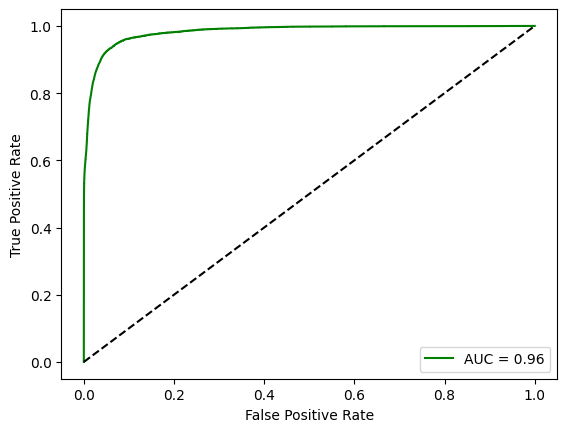

<Figure size 800x600 with 0 Axes>

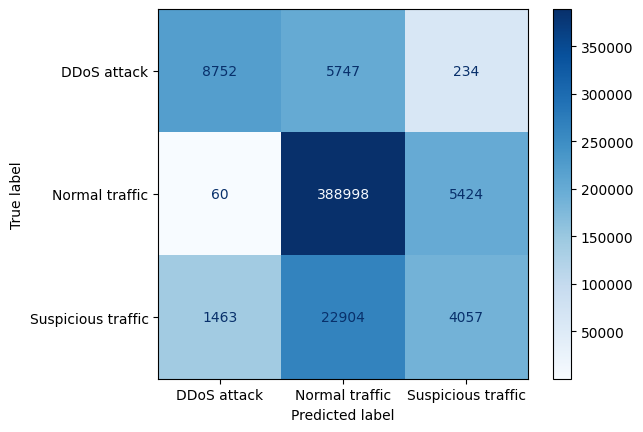

In [3]:
events_train = pd.read_csv("/home/appuser/data/train/A_B_inferred_attack_code.csv")
events_test = pd.read_csv("/home/appuser/data/gen/D_inferred_attack_code.csv")

events_combined = pd.concat([events_train, events_test])
num_train_sample = events_train.shape[0]

train_catboost_cls(events_combined, num_train_sample)